In [1]:
import numpy as np
import pandas as pd

import scipy

import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()

# Домашнее задание по курсу анализа данных
Версия от 11.12.2021

Всего 50 баллов = 40 основных + 10 дополнительных

**Оценка**  = (Количество баллов за работу*2 + 20)/10

**Мягкий дедлайн: 18.12.2021  23:59**

**Жесткий дедлайн: 20.12.2021  8:59**

Присылать решение ссылкой на ваш **github** в телеграмм **@Aleron75** или на почту **milenkin.aa@phystech.edu**

**Автор:** Миленькин Александр

In [2]:
data_path = "https://raw.githubusercontent.com/a-milenkin/mipt_data_science_2021/main/data/people_data_clustering.csv"
data = pd.read_csv(data_path, index_col=0)
print("Размеры датасета", data.shape)
data.head()

Размеры датасета (6000, 9)


,was_married,children,salary,sex,age,profession,home_cost,drive_info,happyness
id,,,,,,,,,
0,1,4.0,4.420530e+07,1,82.0,Engineer,1.003674e+07,NaN,0.727499
1,1,2.0,1.737490e+08,1,32.0,Doctor,1.014051e+07,0.0,0.383234
2,1,6.0,2.489055e+08,1,14.0,Entertainment,1.043318e+07,NaN,0.432142
3,0,1.0,1.268718e+08,0,10.0,Lawyer,1.004299e+07,NaN,0.377987
4,1,9.0,8.596042e+07,1,99.0,Artist,1.021908e+07,NaN,0.657579


<div class="alert alert-info">
<b>Про Датасет</b>
    
Датасет представляет собой информацию по жителям некоторого города.

* `was_married` - Был ли когда-либо женат/замужем
* `children` - Количество детей
* `salary` - Уровень зарплаты
* `sex` - Пол (0 - женщина, 1 - мужчина)
* `age` - Возраст
* `home_cost` - Сумарная стоимость жилья/недвижимости
* `Professon` - Профессия
* `drive_info` - Есть ли водительские права
* `happyness` - уровень счастья по результатам опроса
    
</div>

<div class="alert alert-info">
<b>Задание</b>

Изучить датасет и, используя класстерный анализ, разбить пользователей на сегменты. Сделать выводы о причинах такой кластеризации.

# Чистка датасета (5 баллов)
* Есть ли дубли в данных? Если есть удалить.
* Найти и удалить выбросы по признаку `home_cost`. (Их не больше 15-х, не меньше 3-х)

In [3]:
# Проверка на дубли
rows = data.groupby(data.columns.tolist(), as_index=False).size()
len([size for size in rows['size'] if size > 1])

0

In [4]:
# Проверка на дубли по индексу
data[data.index.duplicated(keep=False)]

,was_married,children,salary,sex,age,profession,home_cost,drive_info,happyness
id,,,,,,,,,
0,1,4.0,4.420530e+07,1,82.0,Engineer,1.003674e+07,NaN,0.727499
1,1,2.0,1.737490e+08,1,32.0,Doctor,1.014051e+07,0.0,0.383234
2,1,6.0,2.489055e+08,1,14.0,Entertainment,1.043318e+07,NaN,0.432142
3,0,1.0,1.268718e+08,0,10.0,Lawyer,1.004299e+07,NaN,0.377987
4,1,9.0,8.596042e+07,1,99.0,Artist,1.021908e+07,NaN,0.657579
...,...,...,...,...,...,...,...,...,...
495,1,0.0,3.589436e+07,1,3.0,Executive,1.007038e+07,1.0,0.599222
496,1,3.0,2.454208e+06,0,20.0,Homemaker,1.009348e+07,1.0,0.259710
497,1,0.0,3.335405e+06,0,17.0,Healthcare,1.016696e+07,0.0,0.258779


In [5]:
# 500 дублей по индексу
data = data[~data.index.duplicated(keep='first')]
data.shape

(5500, 9)

<AxesSubplot:>

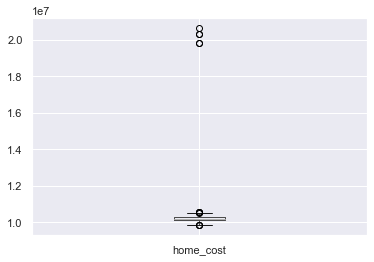

In [6]:
# Работа с выбросами
data.boxplot('home_cost')

<AxesSubplot:>

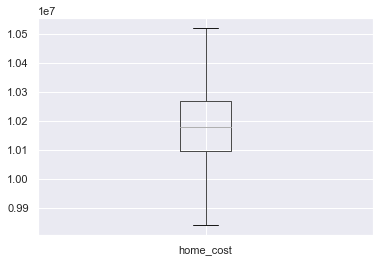

In [7]:
from matplotlib.cbook import boxplot_stats
stats = boxplot_stats(data.home_cost)
for outlier in stats[0]['fliers']:
    data = data.loc[(data['home_cost'] != outlier)]
data.boxplot('home_cost')

In [8]:
# 12 выбросов
data.shape

(5488, 9)

# Проверка гипотез (15 баллов)

<div class="alert alert-info">

<b>Описание заданий раздела:</b>    
    
В этом разделел вам предстоит:
* Проверить предложенные утверждения визуально.
* Применить подходящий статистический критерий, чтобы окончательно доказать или опровергнуть гипотезы на снове этих данных.

<div class="alert alert-warning">
    
* Правда ли женщины в среднем имеют более высокую зарплату, чем мужчины?

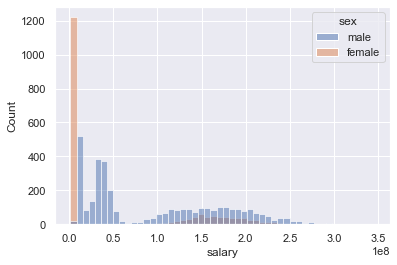

In [9]:
data_copy_sex = data.copy(deep=True)
# Перекодируем пол обратно в "категориальный" (на самом деле бинарный) признак для читаемости на графике
data_copy_sex['sex'] = data_copy_sex['sex'].map({0: 'female', 1: 'male'})
sns.histplot(x='salary', hue='sex', data=data_copy_sex, bins=50);

In [10]:
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu

# Распределение не нормальное, используем критерий Манна-Уитни

female_salary = data_copy_sex[data_copy_sex['sex'] == 'female']['salary']
male_salary = data_copy_sex[data_copy_sex['sex'] == 'male']['salary']

f, pvalue = mannwhitneyu(female_salary, male_salary)

print(f, pvalue)

alph = 0.05

if pvalue < alph:
    print('В среднем отличия есть')
else:
    print('В среднем отличий нет')

1702978.0 6.233989483673052e-195
В среднем отличия есть


In [11]:
print("Среднее для мужчин:")
print(male_salary.mean())
print("Среднее для женщин:")
print(female_salary.mean())

Среднее для мужчин:
98276200.77621458
Среднее для женщин:
58063511.263454035


Нулевая гипотеза - мужчины и женщины в среднем зарабатывают одинаково <- отвергаем, различия есть. 

Из графика и из полученных значений видим, что мужчины в среднем зарабатывают больше женщин.

<div class="alert alert-warning">
    
* Правда ли, что инженеры (Engineer) зарабатывают в среднем больше, чем люди из сферы развлечений (Entertainment)?

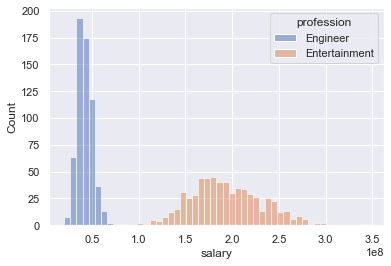

In [12]:
profession_view = data[(data['profession'] == 'Engineer') | (data['profession'] == 'Entertainment')]
sns.histplot(x='salary', hue='profession', data=profession_view, bins=50);

In [13]:
engineer_salary = profession_view[profession_view['profession'] == 'Engineer']['salary']
entertainment_salary = profession_view[profession_view['profession'] == 'Entertainment']['salary']

# Распределение нормальное, используем критерий Стьюдента

f, pvalue = ttest_ind(engineer_salary, entertainment_salary)

print(f, pvalue)

alph = 0.05

if pvalue < alph:
    print('В среднем отличия есть')
else:
    print('В среднем отличий нет')

-96.27173168501587 0.0
В среднем отличия есть


На данном графике очевидно, что у людей с профессией Entertainment в среднем  зарплата больше, чем у людей с профессией Engineer.

<div class="alert alert-warning">
    
* Правда ли, что те, у кого больше трех детей зарабатывают в среднем больше, чем те, у кого меньше или трое детей?

In [14]:
data_copy_children = data.copy(deep=True)
data_copy_children['children'] = data_copy_children['children'].map({0: '1-3', 1: '1-3', 2: '1-3', 3: '1-3', 4: '4+', 5: '4+', 6: '4+', 9: '4+'})

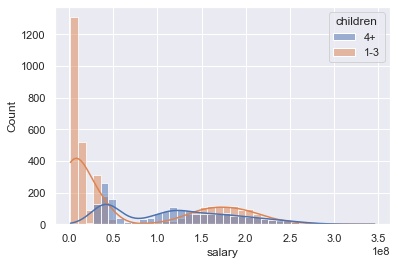

In [15]:
sns.histplot(x='salary', hue='children', data=data_copy_children, kde=True, bins=40);

In [16]:
l_children_salary = data_copy_children[data_copy_children['children'] == '1-3']['salary']
g_children_salary = data_copy_children[data_copy_children['children'] == '4+']['salary']

f, pvalue = mannwhitneyu(g_children_salary, l_children_salary)

print(f, pvalue)

alph = 0.05

if pvalue < alph:
    print('В среднем отличия есть')
else:
    print('В среднем отличий нет')

1786625.0 1.441716040169626e-175
В среднем отличия есть


In [17]:
print("Среднее для с 1-3 детьми:")
print(l_children_salary.mean())
print("Среднее для с 4+ детьми:")
print(g_children_salary.mean())

Среднее для с 1-3 детьми:
67831934.33641918
Среднее для с 4+ детьми:
118775199.43204974


Аналогично первому пункту отклоняем нулевую гипотезу, из полученных данных видим, что те, у кого больше 3 детей зарплата в среднем выше.

<div class="alert alert-warning">
    
* Правда ли, что дома художники (Artist) живут в домах, которые в среднем дороже или дешевле, чем дома адвокатов (Lawyer)?

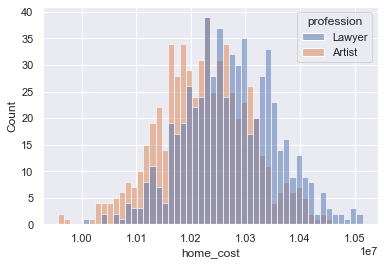

In [18]:
profession_view = data[(data['profession'] == 'Artist') | (data['profession'] == 'Lawyer')]
sns.histplot(x='home_cost', hue='profession', data=profession_view, bins=50);

In [19]:
artist_home_cost = profession_view[profession_view['profession'] == 'Artist']['home_cost']
lawyer_home_cost = profession_view[profession_view['profession'] == 'Lawyer']['home_cost']

f, pvalue = ttest_ind(artist_home_cost, lawyer_home_cost)

print(f, pvalue)

alph = 0.05

if pvalue < alph:
    print('В среднем отличия есть')
else:
    print('В среднем отличий нет')

-9.79692432338105 7.269892973343795e-22
В среднем отличия есть


In [20]:
print("Среднее для Artist:")
print(artist_home_cost.mean())
print("Среднее для Lawyer:")
print(lawyer_home_cost.mean())

Среднее для Artist:
10224471.34241643
Среднее для Lawyer:
10272018.378248058


На графике в целом видно, что у людей с профессией Lawyer в среднем стоимость дома больше, чем у людей с профессией Artist. Это подтверждают и средние значения этого признака.

<div class="alert alert-warning">
    
* Прада ли, что недвижимость у бывавших в браке в среднем дороже, чем у не бывавших в браке?

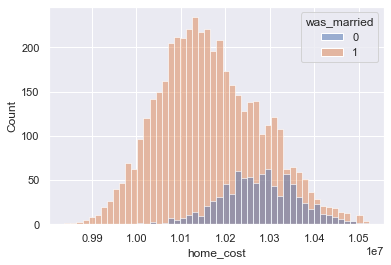

In [21]:
sns.histplot(x='home_cost', hue='was_married', data=data, bins=50);

In [22]:
married_home_cost = data[data['was_married'] == 1]['home_cost']
single_home_cost = data[data['was_married'] == 0]['home_cost']

f, pvalue = ttest_ind(married_home_cost, single_home_cost)

print(f, pvalue)

alph = 0.05

if pvalue < alph:
    print('В среднем отличия есть')
else:
    print('В среднем отличий нет')

-26.824482628356737 4.801333497854458e-149
В среднем отличия есть


In [23]:
print("Среднее для женатых:")
print(married_home_cost.mean())
print("Среднее для одиночек:")
print(single_home_cost.mean())

Среднее для женатых:
10166004.1882845
Среднее для одиночек:
10276600.5326621


<div class="alert alert-warning">
    
* Прада ли, что мужчины в среднем чаще бывают в браке, чем женщины?

**Подсказка** - воспользуйтесь критерием хи-квадрат из библиотеки scipy

In [24]:
married_male = data_copy_sex[(data_copy_sex['sex'] == 'male') & (data_copy_sex['was_married'] == 1)].shape[0]
married_female = data_copy_sex[(data_copy_sex['sex'] == 'female') & (data_copy_sex['was_married'] == 1)].shape[0]
single_male = data_copy_sex[(data_copy_sex['sex'] == 'male') & (data_copy_sex['was_married'] == 0)].shape[0]
single_female = data_copy_sex[(data_copy_sex['sex'] == 'female') & (data_copy_sex['was_married'] == 0)].shape[0]

In [25]:
contingency_table = pd.DataFrame(
    [
     [married_male, married_female],
     [single_male, single_female]
    ],
    columns = ['male', 'female'],
    index = ['married', 'single'])
contingency_table

,male,female
married,3395,1225
single,259,609


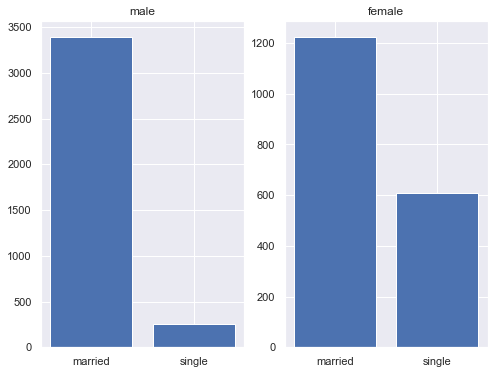

In [26]:
fig, axs = plt.subplots(1,2, figsize=(8,6))

axs[0].bar(contingency_table.index, contingency_table['male'])
axs[0].set_title('male')
axs[1].bar(contingency_table.index, contingency_table['female'])
axs[1].set_title('female');

In [27]:
from scipy.stats import chi2_contingency

chi, pvalue, dof, exp = chi2_contingency(contingency_table.values)

alph = 0.05

print(pvalue)

if pvalue < alph:
  print('Отвергаем нулевую, принимаем H1')
else:
  print('Принимаем нулевую')

1.205566485008978e-137
Отвергаем нулевую, принимаем H1


Нулевая гипотеза - женщины и мужчины в среднем одинаково бывают в браке <- отвергаем => есть отличие. Из графика видно, что мужчины в среднем чаще бывают в браке.

# Гипотезы при множественном тестировании (10 баллов)

In [28]:
# Подсказка: 
# - дисперсионнай анализ  f_oneway()
# - Крускал Уоллиса

<div class="alert alert-warning">
    
* Правда ли между представителями таких профессий как, **Homemaker**, **Marketing**, **Healthcare** и **Executive** в среднем  зарплаты не отличаются между собой? Ответ подкрепите визуализацией и подходящим статистическим критерием. 

In [29]:
from scipy.stats import f_oneway

# В данном случае можно использовать как Краскала, так и дисперсионный анализ

homemaker_salary = data[data['profession'] == 'Homemaker']['salary']
marketing_salary = data[data['profession'] == 'Marketing']['salary']
healthcare_salary = data[data['profession'] == 'Healthcare']['salary']
executive_salary = data[data['profession'] == 'Executive']['salary']

F, pvalue = f_oneway(homemaker_salary, marketing_salary, healthcare_salary, executive_salary)

alpha = 0.05
print(F, pvalue)

if pvalue > 2 * alpha:
    print('Не отвергаем H0')
elif pvalue < alpha:
    print('Отклоняем H0')
else:
    print('Неопределенность на границе значимости')

11510.50699607355 0.0
Отклоняем H0


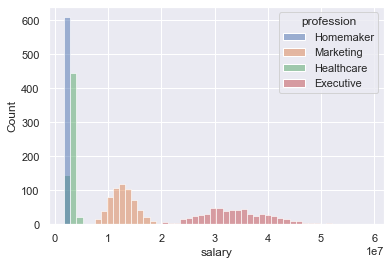

In [30]:
profession_view = data[(data['profession'] == 'Homemaker') | (data['profession'] == 'Marketing') | (data['profession'] == 'Healthcare') | (data['profession'] == 'Executive')]
sns.histplot(x='salary', hue='profession', data=profession_view, bins=50);

In [31]:
from scipy.stats import kruskal

F, pvalue = kruskal(homemaker_salary, marketing_salary, healthcare_salary, executive_salary)

alpha = 0.05
print(F, pvalue)

if pvalue > 2 * alpha:
    print('Не отвергаем H0')
elif pvalue < alpha:
    print('Отклоняем H0')
else:
    print('Неопределенность на границе значимости')

2271.323758329165 0.0
Отклоняем H0


И по тестам, и по графику видно, что в среднем зарплаты между этими профессиями отличаются

<div class="alert alert-warning">
    
* Правда ли между представителями таких профессий как, **Doctor**, **Entertainment** и **Lawyer** в среднем  зарплаты не отличаются между собой? Ответ подкрепите визуализацией и подходящим статистическим критерием. 

In [32]:
doctor_salary = data[data['profession'] == 'Doctor']['salary']
entertainment_salary = data[data['profession'] == 'Entertainment']['salary']
lawyer_salary = data[data['profession'] == 'Lawyer']['salary']

F, pvalue = f_oneway(doctor_salary, entertainment_salary, lawyer_salary)

alpha = 0.05
print(F, pvalue)

if pvalue > 2 * alpha:
    print('Не отвергаем H0')
elif pvalue < alpha:
    print('Отклоняем H0')
else:
    print('Неопределенность на границе значимости')

78.0156679902356 3.0782539431452083e-33
Отклоняем H0


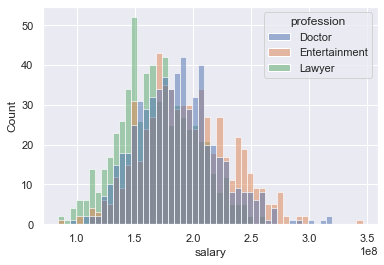

In [33]:
profession_view = data[(data['profession'] == 'Doctor') | (data['profession'] == 'Entertainment') | (data['profession'] == 'Lawyer')]
sns.histplot(x='salary', hue='profession', data=profession_view, bins=50);

In [34]:
F, pvalue = kruskal(doctor_salary, entertainment_salary, lawyer_salary)

alpha = 0.05
print(F, pvalue)

if pvalue > 2 * alpha:
    print('Не отвергаем H0')
elif pvalue < alpha:
    print('Отклоняем H0')
else:
    print('Неопределенность на границе значимости')

132.24530037958357 1.9199852563686465e-29
Отклоняем H0


Оба теста отклонили нулевую гипотезу => различия между ними есть. По графику в целом видим, что они действительно присутствуют.

# Регрессионный Анализ (20 баллов)

Взглянем от чего зависит уровень счастья

In [35]:
import statsmodels.formula.api as smf

# Рекомендации: 
# Используйте библиотку statsmodels для оценки вклада каждого фактора
# Выведения отчета о модели - model.summary()

In [36]:
from sklearn.preprocessing import StandardScaler 

# Нормализуем данные перед регрессионным анализом

normalized_data = data.copy(deep=True)

col_names = ['children', 'salary', 'age', 'home_cost']
features = normalized_data[col_names]

scaler = StandardScaler()
features = scaler.fit_transform(features.values)

normalized_data[col_names] = features
normalized_data

,was_married,children,salary,sex,age,profession,home_cost,drive_info,happyness
id,,,,,,,,,
0,1,0.389310,-0.507245,1,1.536534,Engineer,-1.238279,NaN,0.727499
1,1,-0.313035,1.109942,1,0.003107,Doctor,-0.362684,0.0,0.383234
2,1,1.091656,2.048175,1,-0.548927,Entertainment,2.106809,NaN,0.432142
3,0,-0.664208,0.524741,0,-0.671601,Lawyer,-1.185617,NaN,0.377987
4,1,2.145174,0.014015,1,2.057900,Artist,0.300263,NaN,0.657579
...,...,...,...,...,...,...,...,...,...
5495,1,-0.664208,-0.907686,1,-0.702269,Marketing,0.733685,0.0,0.400123
5496,1,1.091656,1.307018,1,-0.579595,Entertainment,1.216542,1.0,0.471274
5497,1,-1.015381,-0.734099,1,-0.886281,Executive,-0.698191,NaN,0.432856


<div class="alert alert-warning">
    
Выполните следующие задания и на основе результатов ответьте на вопросы:

* Постройте регрессионную модель зависимости уровня счастья от приведенных факторов (was_married, children, salary, sex, age, home_cost)
* Существует ли связь между уровнем счастья и зарплатой?

* Насколько сильны эти отношения?

* Как факт брака способствуют стоимости недвижимости?

* Зная влияние каждого фактора, можем ли мы предсказать уровень счастья?

* Постройте график зависимостей целевой переменной от приведенных числовых факторов. 
    
* Какие признаки не влияют на уровень счастья? (стат. значимость)
    
* Какой признак самый сильный?
    
* Постройте график остатков. Всю ли информацию смогла извлечь ваша модель из данных?

* Наблюдается ли гетероскедастичность в остатках?
    
* Есть ли в данных автокоррелированность?  

In [37]:
normal_model = smf.ols('happyness ~ was_married + children + salary + sex + age + home_cost', data=normalized_data)
normal_res = normal_model.fit()
print(normal_res.summary())

                            OLS Regression Results                            
Dep. Variable:              happyness   R-squared:                       0.487
Model:                            OLS   Adj. R-squared:                  0.487
Method:                 Least Squares   F-statistic:                     868.7
Date:                Fri, 17 Dec 2021   Prob (F-statistic):               0.00
Time:                        22:02:58   Log-Likelihood:                 4341.6
No. Observations:                5488   AIC:                            -8669.
Df Residuals:                    5481   BIC:                            -8623.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.3709      0.005     74.796      

In [38]:
# Смотрим на pvalue, значимость как и всегда 0.05
normal_res.pvalues

Intercept       0.000000e+00
was_married     1.301359e-16
children        7.372751e-15
salary          5.951975e-11
sex             1.343229e-60
age            6.510353e-120
home_cost       2.475680e-01
dtype: float64

In [39]:
# Смотрим корреляцию между was_married и home_cost, чтобы узнать влияние брака на стоимость недвижимости
normalized_data[['was_married','home_cost']].corr()

,was_married,home_cost
was_married,1.000000,-0.340519
home_cost,-0.340519,1.000000


In [40]:
# Вытаскиваем остатки из модели и проверяем на пропуски в данных
normalized_data['residuals'] = normal_res.resid
normalized_data['residuals'].isna().sum()

0

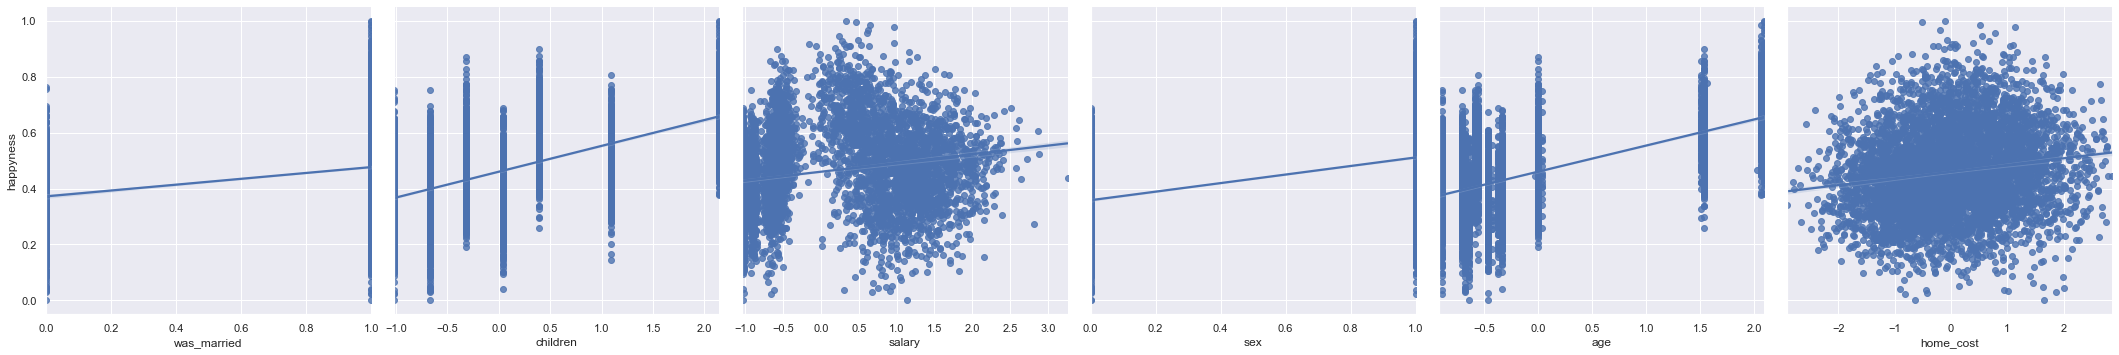

In [41]:
# График зависимости целевой переменной от приведенных числовых факторов
sns.pairplot(normalized_data, y_vars='happyness', x_vars=['was_married', 'children', 'salary', 'sex', 'age', 'home_cost'], height=5, kind='reg', diag_kind=None);

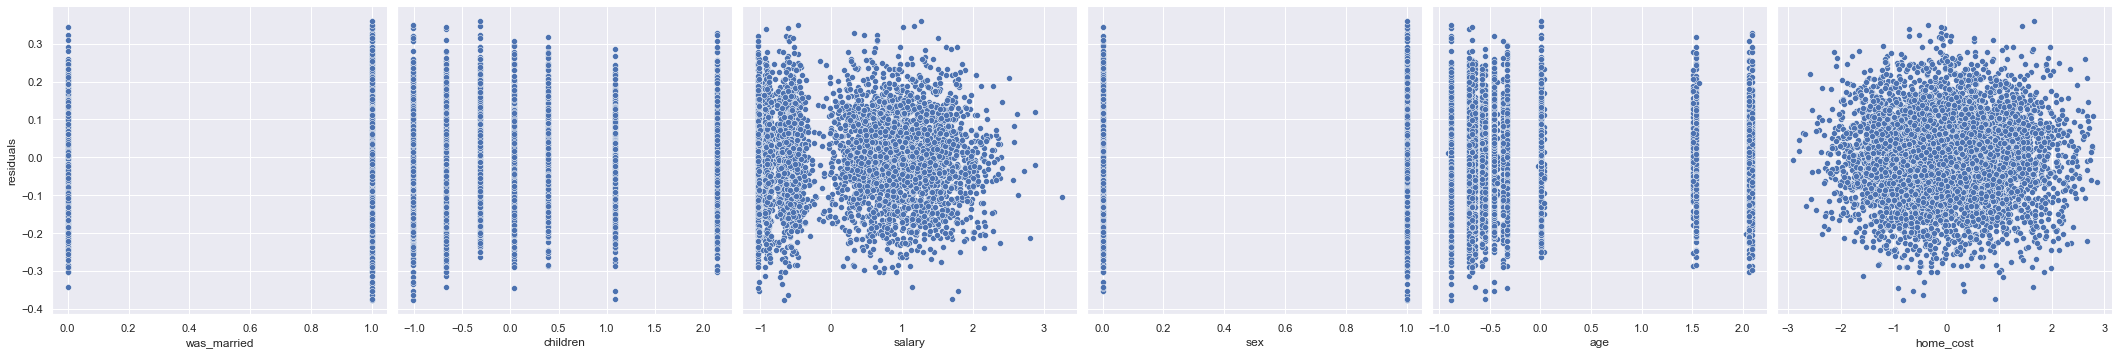

In [42]:
# График остатков
sns.pairplot(normalized_data, y_vars='residuals', x_vars=['was_married', 'children', 'salary', 'sex', 'age', 'home_cost'], height=5, diag_kind=None);

In [43]:
# Тест на гетероскедастичность
from statsmodels.stats.diagnostic import het_breuschpagan

_, _, _, pvalue = het_breuschpagan(normal_res.resid, normalized_data[['was_married', 'children', 'salary', 'sex', 'age', 'home_cost']].values)

print(pvalue)

0.0


1) Существует

2) Сила с стандатизированным коэффициентом 0.0185

3) Связь есть. Отрицательная корреляция со значением -0.3405 (Люди в браке имеют более дешевую недвижимость)

4) Можем, но довольно приблизительно (R-squared: 0.487, т.е. модель описывает только 48% дисперсии зависимой переменной)

5) Не влияет home_cost т.к. pvalue > 0.05

6) Самый сильный признак - sex

7) Наблюдается гомоскедастичность (нет зависимости на графиках + тест)

8) Автокоррелированность отсутствует (статистика Дарбина-Уотсона в районе 2)


In [44]:
# Аналогично для ненормализованных данных
# Коэффициенты в данном случае будут нестандартизованными, поэтому использование их для сравнения будет некорректно

model = smf.ols('happyness ~ was_married + children + salary + sex + age + home_cost', data=data)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              happyness   R-squared:                       0.487
Model:                            OLS   Adj. R-squared:                  0.487
Method:                 Least Squares   F-statistic:                     868.7
Date:                Fri, 17 Dec 2021   Prob (F-statistic):               0.00
Time:                        22:03:02   Log-Likelihood:                 4341.6
No. Observations:                5488   AIC:                            -8669.
Df Residuals:                    5481   BIC:                            -8623.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0656      0.175      0.376      

In [45]:
res.pvalues

Intercept       7.071119e-01
was_married     1.301359e-16
children        7.372754e-15
salary          5.951970e-11
sex             1.343229e-60
age            6.510353e-120
home_cost       2.475680e-01
dtype: float64

In [46]:
data[['was_married','home_cost']].corr()

,was_married,home_cost
was_married,1.000000,-0.340519
home_cost,-0.340519,1.000000


In [47]:
data['residuals'] = res.resid
data['residuals'].isna().sum()

0

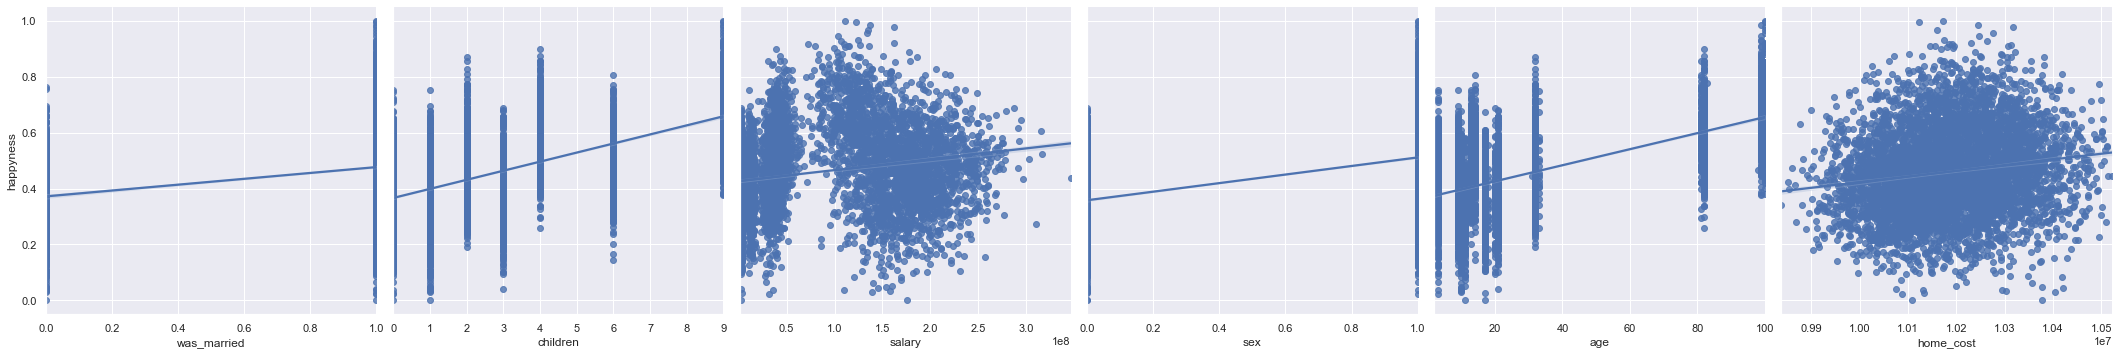

In [48]:
sns.pairplot(data, y_vars='happyness', x_vars=['was_married', 'children', 'salary', 'sex', 'age', 'home_cost'], height=5, kind='reg', diag_kind=None);

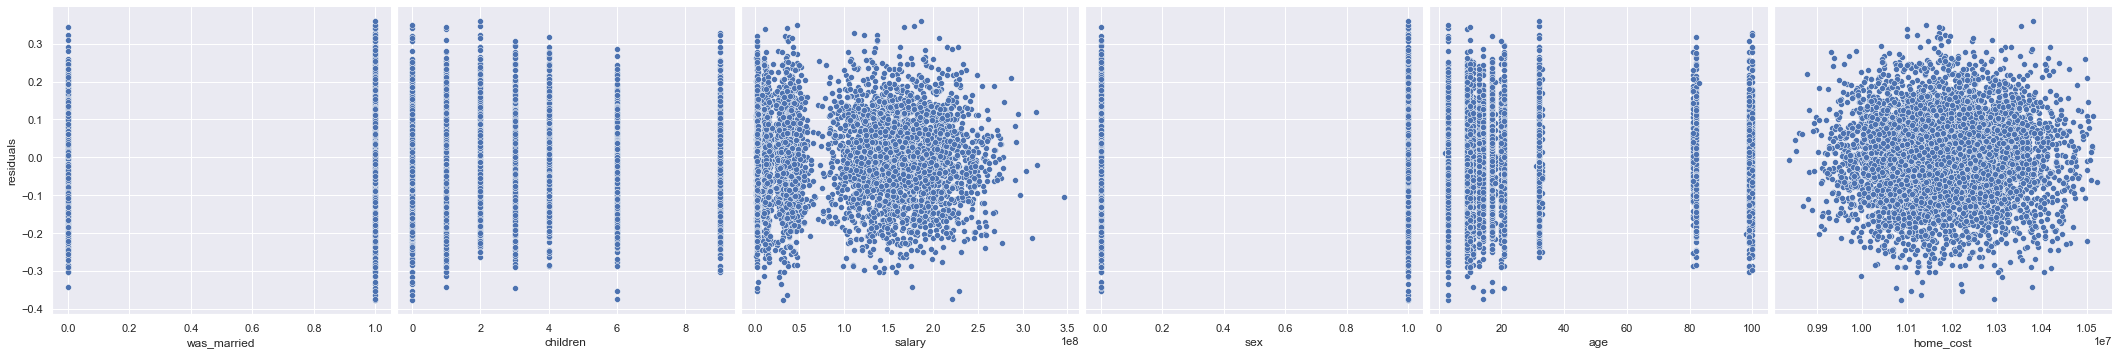

In [49]:
sns.pairplot(data, y_vars='residuals', x_vars=['was_married', 'children', 'salary', 'sex', 'age', 'home_cost'], height=5, diag_kind=None);

In [50]:
_, _, _, pvalue = het_breuschpagan(normal_res.resid, normalized_data[['was_married', 'children', 'salary', 'sex', 'age', 'home_cost']].values)

print(pvalue)

0.0


# Дополнительные баллы (+10 баллов)
* Аккуратный и понятный код **+5 баллов**
* Присутствуют лаконичные и понятные комментарии **+5 балов**